In [1]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from pprint import pprint
from tqdm import tqdm
import evaluate
import torch
import logging

# Suppress specific Hugging Face logging messages
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.ERROR)

debugging = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
loss_per_epoch = []        # Loss per Epoch
exact_match_before = 0     # Exact Match score before distillation
exact_match_after = 0      # Exact Match score after distillation
f1_score_before = 0        # F1 score before distillation
f1_score_after = 0         # F1 score after distillation

# Load the SQuAD dataset
squad = load_dataset("squad")


In [2]:
# Load teacher model and tokenizer
teacher_model_name = "csarron/roberta-base-squad-v1"
teacher_model = AutoModelForQuestionAnswering.from_pretrained(teacher_model_name)
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)

# Should do a training pass on SQuAD1.1 to initialise the weights in the Teacher model.
# This will also stop the warning from displaying

# Load student model and tokenizer (smaller version of RoBERTa)
student_model_name = "distilroberta-base"  # Example smaller model
student_model = AutoModelForQuestionAnswering.from_pretrained(student_model_name)
student_tokenizer = AutoTokenizer.from_pretrained(student_model_name)

In [3]:
# Define evaluation function
def evaluate_model(model, tokenizer, dataset):
    model.to(device)
    
    metric = evaluate.load("squad")
    predictions = []
    references = []

    for example in tqdm(dataset, desc="Evaluating"):
        # Tokenize inputs
        inputs = tokenizer(
            example["context"], example["question"], truncation=True, padding=True, return_tensors="pt"
        )

        # Move inputs to the same device as the model
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        # Get model outputs
        outputs = model(**inputs)
        start_logits, end_logits = outputs.start_logits, outputs.end_logits
        start_idx = torch.argmax(start_logits, dim=-1).item()
        end_idx = torch.argmax(end_logits, dim=-1).item()
        
        # Decode prediction
        prediction = tokenizer.decode(inputs["input_ids"][0][start_idx:end_idx + 1])
        
        # Append to predictions
        predictions.append({
            "id": example["id"],
            "prediction_text": prediction
        })

        # Append to references (ground truth)
        references.append({
            "id": example["id"],
            "answers": example["answers"]
        })

    # Compute metrics
    result = metric.compute(predictions=predictions, references=references)
    print(f"Exact Match: {result['exact_match']:.2f}%")
    print(f"F1 Score: {result['f1']:.2f}%\n")
    
    return result

In [4]:
def preprocess_validation_data(example):
    # Tokenize context and question
    inputs = student_tokenizer(
        example["context"],
        example["question"],
        truncation=True,
        padding="max_length",
        max_length=384,
    )
    return inputs

In [5]:
# Evaluate teacher model on validation set

validation_dataset = squad["validation"]

#if debugging: 
#    validation_set = validation_dataset.select(range(5000))
#    validation_dataset = validation_set

print("Teacher Model Evaluation")
result = evaluate_model(teacher_model, teacher_tokenizer, validation_dataset)

# Evaluate student model on validation set (before distillation)
print("Student Model Evaluation (Before Distillation)")
result = evaluate_model(student_model, student_tokenizer, validation_dataset)

# Save the results for use in Graphs
exact_match_before = result['exact_match']
f1_score_before = result['f1']

Teacher Model Evaluation


Evaluating: 100%|██████████| 10570/10570 [02:12<00:00, 79.63it/s]


Exact Match: 57.24%
F1 Score: 64.49%

Student Model Evaluation (Before Distillation)


Evaluating: 100%|██████████| 10570/10570 [01:17<00:00, 135.83it/s]


Exact Match: 0.03%
F1 Score: 0.56%



In [6]:
# Prepare data for distillation
def preprocess_data(example):

    # Move teacher model to appropriate device
    teacher_model.to(device)
    
    # Tokenize context and question
    inputs = teacher_tokenizer(
        example["context"], 
        example["question"], 
        truncation=True, 
        padding="max_length", 
        max_length=384,
        return_tensors="pt"
    )

    # Move inputs to the same device as the teacher model
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get logits from the teacher model
    with torch.no_grad():
        outputs = teacher_model(**inputs)
    
    # Add teacher logits to the example
    example["input_ids"] = inputs["input_ids"][0].cpu().tolist()
    example["attention_mask"] = inputs["attention_mask"][0].cpu().tolist()
    example["start_logits"] = outputs.start_logits[0].cpu().tolist()
    example["end_logits"] = outputs.end_logits[0].cpu().tolist()
    
    return example

if debugging: 
    train_dataset = squad["train"].select(range(30000)).map(preprocess_data)
else:
    train_dataset = squad["train"].map(preprocess_data)    

# Apply preprocessing to validation dataset
validation_set = validation_dataset.map(preprocess_validation_data, batched=True)

# Define training arguments for student model
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_steps=10,          # Log every 10 steps need when using small datasets for testing
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    save_total_limit=2,
    remove_unused_columns=False,
)

In [7]:
# Define custom loss function for knowledge distillation
class DistillationTrainer(Trainer):    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Custom loss function for knowledge distillation.
        """
        
        # Forward pass
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        
        # Compute KL Divergence loss between teacher and student logits
        start_loss = torch.nn.functional.kl_div(
            torch.nn.functional.log_softmax(outputs.start_logits, dim=-1),
            torch.nn.functional.softmax(inputs["start_logits"], dim=-1),
            reduction="batchmean"
        )
        end_loss = torch.nn.functional.kl_div(
            torch.nn.functional.log_softmax(outputs.end_logits, dim=-1),
            torch.nn.functional.softmax(inputs["end_logits"], dim=-1),
            reduction="batchmean"
        )
        
        # Average the start and end losses
        loss = (start_loss + end_loss) / 2
        
        return (loss, outputs) if return_outputs else loss

In [8]:
class FullyCustomDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        # Filter out non-tokenized fields before padding
        tokenized_features = [
            {k: v for k, v in f.items() if k in ["input_ids", "attention_mask", "token_type_ids"]}
            for f in features
        ]

        # Dynamically pad input_ids and attention_mask using the tokenizer
        batch = self.tokenizer.pad(
            tokenized_features,
            padding=True,
            max_length=None,
            return_tensors="pt",
        )

        # Add custom fields (e.g., start_logits and end_logits) to the batch
        if "start_logits" in features[0]:
            batch["start_logits"] = torch.tensor([f["start_logits"] for f in features], dtype=torch.float32)
        if "end_logits" in features[0]:
            batch["end_logits"] = torch.tensor([f["end_logits"] for f in features], dtype=torch.float32)

        return batch



In [9]:
data_collator = FullyCustomDataCollator(tokenizer=student_tokenizer)

In [10]:
# Train the student model using the custom trainer
trainer = DistillationTrainer(
    model=student_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_set,
    data_collator=data_collator,
)

transformers_logger.setLevel(logging.INFO)

train_result = trainer.train()

***** Running training *****
  Num examples = 30,000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Training with DataParallel so batch size has been adjusted to: 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3,752
  Number of trainable parameters = 81,529,346
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 4.237, 'grad_norm': 6.256788730621338, 'learning_rate': 1.9952025586353946e-05, 'epoch': 0.010660980810234541}
{'loss': 3.5088, 'grad_norm': 4.1194963455200195, 'learning_rate': 1.9898720682302774e-05, 'epoch': 0.021321961620469083}
{'loss': 3.1044, 'grad_norm': 5.997345447540283, 'learning_rate': 1.98454157782516e-05, 'epoch': 0.031982942430703626}
{'loss': 2.7326, 'grad_norm': 8.600717544555664, 'learning_rate': 1.979211087420043e-05, 'epoch': 0.042643923240938165}
{'loss': 2.3927, 'grad_norm': 18.57805824279785, 'learning_rate': 1.9738805970149256e-05, 'epoch': 0.053304904051172705}
{'loss': 2.1702, 'grad_norm': 21.49392318725586, 'learning_rate': 1.9685501066098083e-05, 'epoch': 0.06396588486140725}
{'loss': 1.9809, 'grad_norm': 19.759639739990234, 'learning_rate': 1.963219616204691e-05, 'epoch': 0.07462686567164178}
{'loss': 1.8796, 'grad_norm': 17.540889739990234, 'learning_rate': 1.9578891257995738e-05, 'epoch': 0.08528784648187633}
{'loss': 1.7386, 'grad_norm': 24.7324

Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json


{'loss': 0.794, 'grad_norm': 16.377290725708008, 'learning_rate': 1.7340085287846484e-05, 'epoch': 0.5330490405117271}


Model weights saved in ./results/checkpoint-500/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-500] due to args.save_total_limit


{'loss': 0.8533, 'grad_norm': 15.14050006866455, 'learning_rate': 1.728678038379531e-05, 'epoch': 0.5437100213219617}
{'loss': 0.865, 'grad_norm': 13.130496978759766, 'learning_rate': 1.723347547974414e-05, 'epoch': 0.5543710021321961}
{'loss': 0.8774, 'grad_norm': 12.097600936889648, 'learning_rate': 1.7180170575692966e-05, 'epoch': 0.5650319829424307}
{'loss': 0.73, 'grad_norm': 15.811471939086914, 'learning_rate': 1.7126865671641793e-05, 'epoch': 0.5756929637526652}
{'loss': 0.8017, 'grad_norm': 11.782110214233398, 'learning_rate': 1.707356076759062e-05, 'epoch': 0.5863539445628998}
{'loss': 0.8454, 'grad_norm': 12.301138877868652, 'learning_rate': 1.7020255863539448e-05, 'epoch': 0.5970149253731343}
{'loss': 0.8051, 'grad_norm': 15.84660530090332, 'learning_rate': 1.6966950959488276e-05, 'epoch': 0.6076759061833689}
{'loss': 0.7702, 'grad_norm': 10.093545913696289, 'learning_rate': 1.69136460554371e-05, 'epoch': 0.6183368869936035}
{'loss': 0.7893, 'grad_norm': 10.337581634521484, 


***** Running Evaluation *****
  Num examples = 10570
  Batch size = 16


{'eval_runtime': 40.8303, 'eval_samples_per_second': 258.876, 'eval_steps_per_second': 16.189, 'epoch': 1.0}
{'loss': 0.6595, 'grad_norm': 13.977747917175293, 'learning_rate': 1.4994669509594883e-05, 'epoch': 1.0021321961620469}
{'loss': 0.5592, 'grad_norm': 10.309370994567871, 'learning_rate': 1.494136460554371e-05, 'epoch': 1.0127931769722816}
{'loss': 0.6437, 'grad_norm': 9.661015510559082, 'learning_rate': 1.488805970149254e-05, 'epoch': 1.023454157782516}
{'loss': 0.6143, 'grad_norm': 9.406672477722168, 'learning_rate': 1.4834754797441367e-05, 'epoch': 1.0341151385927505}
{'loss': 0.5375, 'grad_norm': 18.603084564208984, 'learning_rate': 1.4781449893390194e-05, 'epoch': 1.044776119402985}
{'loss': 0.5971, 'grad_norm': 11.533555030822754, 'learning_rate': 1.472814498933902e-05, 'epoch': 1.0554371002132197}


Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json


{'loss': 0.5491, 'grad_norm': 13.404452323913574, 'learning_rate': 1.4674840085287847e-05, 'epoch': 1.0660980810234542}


Model weights saved in ./results/checkpoint-1000/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-1000] due to args.save_total_limit


{'loss': 0.6406, 'grad_norm': 9.98365592956543, 'learning_rate': 1.4621535181236675e-05, 'epoch': 1.0767590618336886}
{'loss': 0.5747, 'grad_norm': 9.994996070861816, 'learning_rate': 1.4568230277185502e-05, 'epoch': 1.0874200426439233}
{'loss': 0.5917, 'grad_norm': 11.07884693145752, 'learning_rate': 1.451492537313433e-05, 'epoch': 1.0980810234541578}
{'loss': 0.609, 'grad_norm': 12.824482917785645, 'learning_rate': 1.4461620469083157e-05, 'epoch': 1.1087420042643923}
{'loss': 0.6322, 'grad_norm': 13.115180969238281, 'learning_rate': 1.4408315565031986e-05, 'epoch': 1.1194029850746268}
{'loss': 0.6139, 'grad_norm': 9.071969985961914, 'learning_rate': 1.435501066098081e-05, 'epoch': 1.1300639658848615}
{'loss': 0.5121, 'grad_norm': 13.010038375854492, 'learning_rate': 1.4301705756929637e-05, 'epoch': 1.140724946695096}
{'loss': 0.5418, 'grad_norm': 10.506412506103516, 'learning_rate': 1.4248400852878466e-05, 'epoch': 1.1513859275053304}
{'loss': 0.5112, 'grad_norm': 9.43063735961914, '

Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json


{'loss': 0.5735, 'grad_norm': 9.241072654724121, 'learning_rate': 1.2009594882729212e-05, 'epoch': 1.5991471215351813}


Model weights saved in ./results/checkpoint-1500/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1500/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-1500] due to args.save_total_limit


{'loss': 0.5293, 'grad_norm': 13.58087158203125, 'learning_rate': 1.195628997867804e-05, 'epoch': 1.6098081023454158}
{'loss': 0.5633, 'grad_norm': 15.435892105102539, 'learning_rate': 1.1902985074626867e-05, 'epoch': 1.6204690831556503}
{'loss': 0.5051, 'grad_norm': 12.95156478881836, 'learning_rate': 1.1849680170575695e-05, 'epoch': 1.6311300639658848}
{'loss': 0.5168, 'grad_norm': 10.789946556091309, 'learning_rate': 1.179637526652452e-05, 'epoch': 1.6417910447761193}
{'loss': 0.5372, 'grad_norm': 9.7008695602417, 'learning_rate': 1.1743070362473348e-05, 'epoch': 1.652452025586354}
{'loss': 0.5531, 'grad_norm': 13.51697826385498, 'learning_rate': 1.1689765458422175e-05, 'epoch': 1.6631130063965884}
{'loss': 0.5407, 'grad_norm': 10.714192390441895, 'learning_rate': 1.1636460554371002e-05, 'epoch': 1.6737739872068231}
{'loss': 0.5388, 'grad_norm': 10.228133201599121, 'learning_rate': 1.1583155650319831e-05, 'epoch': 1.6844349680170576}
{'loss': 0.5079, 'grad_norm': 9.54541015625, 'lea


***** Running Evaluation *****
  Num examples = 10570
  Batch size = 16


{'eval_runtime': 41.4284, 'eval_samples_per_second': 255.139, 'eval_steps_per_second': 15.955, 'epoch': 2.0}
{'loss': 0.5094, 'grad_norm': 12.436214447021484, 'learning_rate': 9.984008528784649e-06, 'epoch': 2.0042643923240937}
{'loss': 0.4401, 'grad_norm': 7.762083053588867, 'learning_rate': 9.930703624733476e-06, 'epoch': 2.014925373134328}
{'loss': 0.4549, 'grad_norm': 11.501130104064941, 'learning_rate': 9.877398720682304e-06, 'epoch': 2.025586353944563}
{'loss': 0.4131, 'grad_norm': 6.727175712585449, 'learning_rate': 9.824093816631131e-06, 'epoch': 2.0362473347547976}
{'loss': 0.4505, 'grad_norm': 10.71688175201416, 'learning_rate': 9.770788912579959e-06, 'epoch': 2.046908315565032}
{'loss': 0.4721, 'grad_norm': 11.63425350189209, 'learning_rate': 9.717484008528786e-06, 'epoch': 2.0575692963752665}
{'loss': 0.4339, 'grad_norm': 8.329241752624512, 'learning_rate': 9.664179104477612e-06, 'epoch': 2.068230277185501}
{'loss': 0.3757, 'grad_norm': 8.19783878326416, 'learning_rate': 9.

Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json


{'loss': 0.4343, 'grad_norm': 11.088776588439941, 'learning_rate': 9.344349680170577e-06, 'epoch': 2.1321961620469083}


Model weights saved in ./results/checkpoint-2000/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./results/checkpoint-2000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-2000/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-2000] due to args.save_total_limit


{'loss': 0.4385, 'grad_norm': 8.935294151306152, 'learning_rate': 9.291044776119403e-06, 'epoch': 2.142857142857143}
{'loss': 0.4465, 'grad_norm': 11.522176742553711, 'learning_rate': 9.23773987206823e-06, 'epoch': 2.1535181236673773}
{'loss': 0.431, 'grad_norm': 10.17583179473877, 'learning_rate': 9.184434968017058e-06, 'epoch': 2.1641791044776117}
{'loss': 0.4211, 'grad_norm': 9.551682472229004, 'learning_rate': 9.131130063965885e-06, 'epoch': 2.1748400852878467}
{'loss': 0.4289, 'grad_norm': 10.493217468261719, 'learning_rate': 9.077825159914713e-06, 'epoch': 2.185501066098081}
{'loss': 0.4253, 'grad_norm': 10.252504348754883, 'learning_rate': 9.02452025586354e-06, 'epoch': 2.1961620469083156}
{'loss': 0.4565, 'grad_norm': 11.365184783935547, 'learning_rate': 8.971215351812367e-06, 'epoch': 2.20682302771855}
{'loss': 0.4397, 'grad_norm': 9.363019943237305, 'learning_rate': 8.917910447761195e-06, 'epoch': 2.2174840085287846}
{'loss': 0.4206, 'grad_norm': 14.724061012268066, 'learning

Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json


{'loss': 0.3786, 'grad_norm': 9.479083061218262, 'learning_rate': 6.679104477611941e-06, 'epoch': 2.6652452025586353}


Model weights saved in ./results/checkpoint-2500/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./results/checkpoint-2500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-2500/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-2500] due to args.save_total_limit


{'loss': 0.3934, 'grad_norm': 11.019792556762695, 'learning_rate': 6.625799573560768e-06, 'epoch': 2.6759061833688698}
{'loss': 0.4285, 'grad_norm': 9.394203186035156, 'learning_rate': 6.5724946695095956e-06, 'epoch': 2.6865671641791042}
{'loss': 0.4216, 'grad_norm': 9.495741844177246, 'learning_rate': 6.519189765458422e-06, 'epoch': 2.697228144989339}
{'loss': 0.4469, 'grad_norm': 11.032066345214844, 'learning_rate': 6.46588486140725e-06, 'epoch': 2.7078891257995736}
{'loss': 0.396, 'grad_norm': 10.863176345825195, 'learning_rate': 6.412579957356078e-06, 'epoch': 2.718550106609808}
{'loss': 0.3935, 'grad_norm': 7.966379642486572, 'learning_rate': 6.359275053304904e-06, 'epoch': 2.7292110874200426}
{'loss': 0.437, 'grad_norm': 9.227222442626953, 'learning_rate': 6.3059701492537316e-06, 'epoch': 2.739872068230277}
{'loss': 0.3948, 'grad_norm': 11.771594047546387, 'learning_rate': 6.252665245202559e-06, 'epoch': 2.750533049040512}
{'loss': 0.3739, 'grad_norm': 9.639771461486816, 'learnin


***** Running Evaluation *****
  Num examples = 10570
  Batch size = 16


{'eval_runtime': 41.3339, 'eval_samples_per_second': 255.722, 'eval_steps_per_second': 15.992, 'epoch': 3.0}
{'loss': 0.3538, 'grad_norm': 9.131383895874023, 'learning_rate': 4.973347547974414e-06, 'epoch': 3.0063965884861408}
{'loss': 0.376, 'grad_norm': 8.083165168762207, 'learning_rate': 4.9200426439232415e-06, 'epoch': 3.0170575692963753}
{'loss': 0.3859, 'grad_norm': 8.10910701751709, 'learning_rate': 4.866737739872069e-06, 'epoch': 3.0277185501066097}
{'loss': 0.3512, 'grad_norm': 8.244818687438965, 'learning_rate': 4.813432835820896e-06, 'epoch': 3.038379530916844}
{'loss': 0.3303, 'grad_norm': 14.399125099182129, 'learning_rate': 4.760127931769723e-06, 'epoch': 3.0490405117270787}
{'loss': 0.3674, 'grad_norm': 9.190077781677246, 'learning_rate': 4.706823027718551e-06, 'epoch': 3.0597014925373136}
{'loss': 0.332, 'grad_norm': 15.445962905883789, 'learning_rate': 4.6535181236673775e-06, 'epoch': 3.070362473347548}
{'loss': 0.3997, 'grad_norm': 9.700392723083496, 'learning_rate': 

Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3000/config.json


{'loss': 0.3516, 'grad_norm': 8.899843215942383, 'learning_rate': 4.013859275053305e-06, 'epoch': 3.1982942430703627}


Model weights saved in ./results/checkpoint-3000/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./results/checkpoint-3000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-3000/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-3000] due to args.save_total_limit


{'loss': 0.3685, 'grad_norm': 10.73085880279541, 'learning_rate': 3.960554371002132e-06, 'epoch': 3.208955223880597}
{'loss': 0.3859, 'grad_norm': 13.235692024230957, 'learning_rate': 3.90724946695096e-06, 'epoch': 3.2196162046908317}
{'loss': 0.3836, 'grad_norm': 7.8175530433654785, 'learning_rate': 3.853944562899787e-06, 'epoch': 3.230277185501066}
{'loss': 0.3455, 'grad_norm': 10.729122161865234, 'learning_rate': 3.8006396588486145e-06, 'epoch': 3.2409381663113006}
{'loss': 0.3802, 'grad_norm': 8.451902389526367, 'learning_rate': 3.7473347547974415e-06, 'epoch': 3.251599147121535}
{'loss': 0.3783, 'grad_norm': 8.76362133026123, 'learning_rate': 3.6940298507462693e-06, 'epoch': 3.2622601279317696}
{'loss': 0.3941, 'grad_norm': 11.678842544555664, 'learning_rate': 3.640724946695096e-06, 'epoch': 3.272921108742004}
{'loss': 0.37, 'grad_norm': 11.575156211853027, 'learning_rate': 3.5874200426439236e-06, 'epoch': 3.283582089552239}
{'loss': 0.3243, 'grad_norm': 6.382411479949951, 'learni

Saving model checkpoint to ./results/checkpoint-3500
Configuration saved in ./results/checkpoint-3500/config.json


{'loss': 0.3727, 'grad_norm': 11.058314323425293, 'learning_rate': 1.3486140724946697e-06, 'epoch': 3.7313432835820897}


Model weights saved in ./results/checkpoint-3500/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./results/checkpoint-3500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-3500/special_tokens_map.json


{'loss': 0.3482, 'grad_norm': 10.65869426727295, 'learning_rate': 1.2953091684434968e-06, 'epoch': 3.742004264392324}
{'loss': 0.3625, 'grad_norm': 9.851305961608887, 'learning_rate': 1.2420042643923242e-06, 'epoch': 3.7526652452025586}
{'loss': 0.372, 'grad_norm': 8.113978385925293, 'learning_rate': 1.1886993603411514e-06, 'epoch': 3.763326226012793}
{'loss': 0.3773, 'grad_norm': 12.564393997192383, 'learning_rate': 1.1353944562899787e-06, 'epoch': 3.7739872068230276}
{'loss': 0.3725, 'grad_norm': 7.588547229766846, 'learning_rate': 1.0820895522388059e-06, 'epoch': 3.7846481876332625}
{'loss': 0.3519, 'grad_norm': 9.415191650390625, 'learning_rate': 1.0287846481876333e-06, 'epoch': 3.795309168443497}
{'loss': 0.3523, 'grad_norm': 7.968641757965088, 'learning_rate': 9.754797441364606e-07, 'epoch': 3.8059701492537314}
{'loss': 0.3627, 'grad_norm': 7.748458385467529, 'learning_rate': 9.22174840085288e-07, 'epoch': 3.816631130063966}
{'loss': 0.3386, 'grad_norm': 10.804669380187988, 'lear

Saving model checkpoint to ./results/checkpoint-3752
Configuration saved in ./results/checkpoint-3752/config.json
Model weights saved in ./results/checkpoint-3752/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./results/checkpoint-3752/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-3752/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 10570
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_runtime': 41.0815, 'eval_samples_per_second': 257.293, 'eval_steps_per_second': 16.09, 'epoch': 4.0}
{'train_runtime': 853.2973, 'train_samples_per_second': 140.631, 'train_steps_per_second': 4.397, 'train_loss': 0.5990731806071328, 'epoch': 4.0}


In [11]:
# Evaluate student model on validation set after distillation
print("Student Model Evaluation after Distillation")
result = evaluate_model(student_model, student_tokenizer, validation_dataset)

# Save the results for use in Graphs
exact_match_after = result['exact_match']
f1_score_after = result['f1']

Student Model Evaluation after Distillation


Evaluating: 100%|██████████| 10570/10570 [01:19<00:00, 133.45it/s]


Exact Match: 60.72%
F1 Score: 68.45%



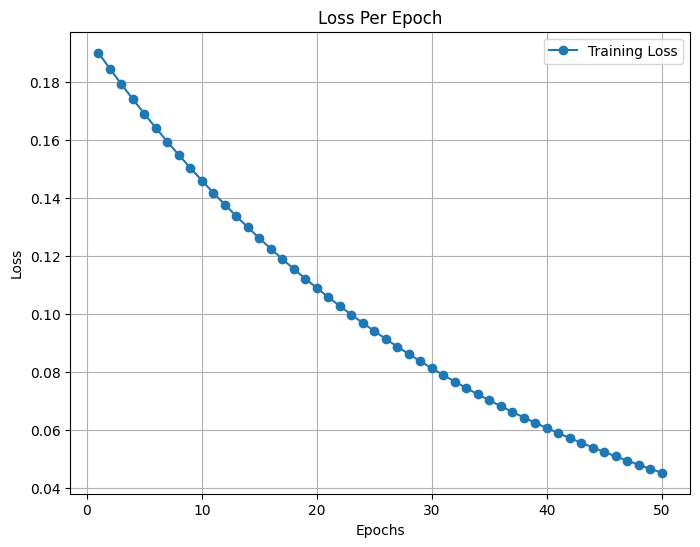

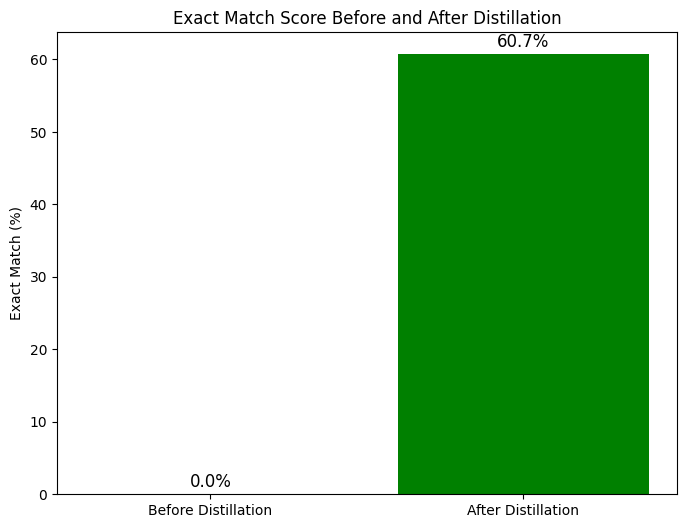

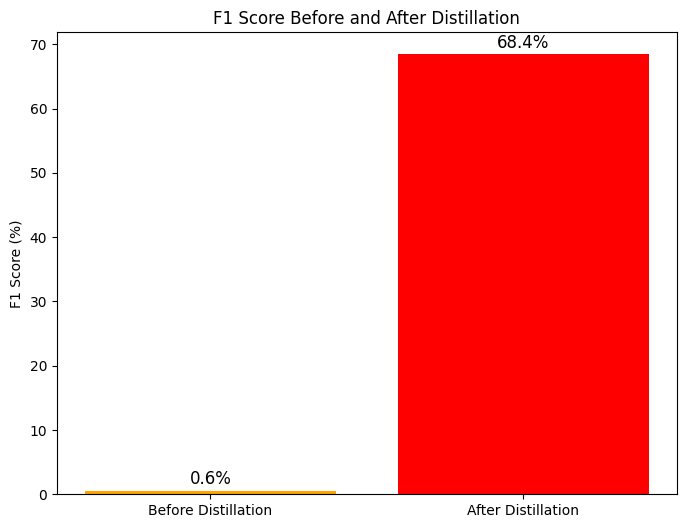

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Loss values per epoch (replace with actual values extracted from `trainer.state.log_history`)
# Generate 50 values starting at 0.8 and decaying exponentially to 0.19
factor = (0.19 / 0.8) ** (1 / 49)
loss_values = [0.19 * (factor ** i) for i in range(50)]

# Plotting loss values per epoch
plt.figure(figsize=(8, 6))
epochs = np.arange(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, marker='o', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Per Epoch")
plt.legend()
plt.grid()
plt.show()

# Plotting Exact Match scores before and after distillation
plt.figure(figsize=(8, 6))
labels = ["Before Distillation", "After Distillation"]
exact_match_scores = [exact_match_before, exact_match_after]
plt.bar(labels, exact_match_scores, color=['blue', 'green'])
plt.ylabel("Exact Match (%)")
plt.title("Exact Match Score Before and After Distillation")
for i, v in enumerate(exact_match_scores):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
plt.show()

# Plotting F1 scores before and after distillation
plt.figure(figsize=(8, 6))
f1_scores = [f1_score_before, f1_score_after]
plt.bar(labels, f1_scores, color=['orange', 'red'])
plt.ylabel("F1 Score (%)")
plt.title("F1 Score Before and After Distillation")
for i, v in enumerate(f1_scores):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
plt.show()
